In [1]:
import numpy as np 
import csv 
import pandas as pd
from scipy.linalg import dft
from scipy import fft
from scipy import ifft
import matplotlib.pyplot as plt 
import bitarray
import pdb
from scipy.io.wavfile import write # For writing to a .wav file
from scipy.io.wavfile import read # For reading from a .wav file to an np array.
from scipy import signal # Module for generating chirp.

In [7]:
# Define constants
N = 1024 #OFDM symbol length
L = 400 #Cyclic prefix length
n = 50 # Number of repetitions of OFDM symbol for transmission
sample_rate = 44100 # Sample rate is 44.1 kHz
chirp_duration = 1
pilot_value = 1+1j # The known value each pilot transmits
FILE_NAME = "clean_input.wav" #name of the file in which we save the pseudo transmitted wave 
pilot_FILE_NAME = 'pilot_' + FILE_NAME
A = 100 #radius of QPSK symbols
chirp_startFrequency = 20
chirp_endFrequency = 20000
introduced_delay = 1000

In [8]:
# Useful helper functions for converting between np arrays and wav files.
def convert_array_to_wav(array, sample_rate, FILE_NAME):
    # Convert the normalized array to a wav file.
    write(FILE_NAME, sample_rate, array)

def convert_wav_to_array(wav_filename):
    rate, array = read(wav_filename)

    return array

## Chirp functions

In [9]:
def generateChirp(startFrequency, endFrequency, sample_rate, duration):
    number_of_samples = int(sample_rate*duration)
    t = list(range(0, number_of_samples+1))
    t = np.array(t)
    t = t / sample_rate
    chirp = signal.chirp(t, startFrequency, duration, endFrequency, method='linear')

    return chirp

def matched_filter(noisy_signal, desired_signal):
    desired_signal = desired_signal.flatten()
    
    correlation = signal.correlate(noisy_signal, desired_signal, mode='same')
    x = np.arange(len(correlation))
    
    max_correlation = np.amax(correlation)
    max_correlation_index = np.argmax(correlation)

    fig, ax = plt.subplots()
    plt.title("Matched filtering")
    plt.xlabel("Sample")
    plt.xlim(max_correlation_index - 50, max_correlation_index + 50)
    plt.ylabel("Correlation between chirp and noisy received signal - amplitude")

    ax.plot(x, correlation)
    fig.show()
    
    
    return max_correlation_index

def find_delay(received_signal, chirp_signal):
    max_corr_index = matched_filter(chirp_signal, chirp_signal)
    max_corr_index_delay = matched_filter(received_signal, chirp_signal)
    
    return max_corr_index_delay - max_corr_index 

In [47]:
chirp_signal = generateChirp(chirp_startFrequency, chirp_endFrequency, sample_rate, chirp_duration)

## Receiver functions

In [48]:
# Functions mainly for use in receiver.

# Calculates the delay present at the receiver in terms of indices in the arrays
# by applying the matched filter to the received signal.
def find_delay(received_signal, chirp_signal):
    max_corr_index = matched_filter(chirp_signal, chirp_signal)
    max_corr_index_delay = matched_filter(received_signal, chirp_signal)
    return max_corr_index_delay - max_corr_index


# Shift the received array left by the amount of the delay. (A certain number of elements) Also cut the array where we expect the transmitted sequency to end.
def calculate_received_signal_without_delay(received_signal, chirp_signal):
    """Takes the received signal and the chirp, to remove the delay and perform synchronisation"""
    delay = find_delay(received_signal, chirp_signal) # Calculate delay

    chirp_length = len(chirp_signal) # Find length of chirp signal
    received_signal_without_delay = received_signal[delay+chirp_length:delay+chirp_length+(n*(N+L))] # Using calculated delay, remove the delay
    return received_signal_without_delay

# Remove cyclic prefix
def removeCP(signal):
    """Remove the cyclic prefix of a signal"""
    # to do: adjust for the whole signal, not just one ofdm block
    return signal[L:(L+N)]

def DFT(OFDM_RX):
    """Compute the discrete Fourier transform of the received OFDM symbol"""
    return fft(OFDM_RX)

def compute_average(two_dimensional_array, N, n):
    """
    Computes the average of a two-dimensional array, element-wise.
    Needs the length of the 'block' N and the number of blocks n.
    For example, inputting np.array([[0,1,2],[2,3,4]]) would return np.array([1,2,3]).
    Note, we call each individual array a 'block' so we are just averaging over them.
    (There should be a nicer 'numpyier' 'vectorised' way of doing this better, try later)
    """
    sum_of_blocks = np.zeros(N) # Initialise as zeros array for summing each block of two-dimensional array
    for block in two_dimensional_array:
        sum_of_blocks = sum_of_blocks + block # Compute sum of each block all together
    average_block = sum_of_blocks / n # Take average by dividing by number of blocks
    return average_block

def compute_average_symbol(received_signal):
    """Takes the received signal without delay, computes the average received OFDM symbol without cyclic prefix, then takes DFT to return in frequency domain"""
    # (In time domain)
    received_signal = np.split(received_signal, n) # Split up received signal into blocks
    OFDM_RX_noCP = [removeCP(received_block) for received_block in received_signal] # Remove cyclic prefix
    OFDM_RX_noCP_average = compute_average(OFDM_RX_noCP, N, n) # Computes the average received block without cyclic prefix
    
    # Note that beyond this point, we are dealing with an 'averaged' block in the time domain because of previous step
    
    # (In frequency domain)
    OFDM_RX_demod_average = DFT(OFDM_RX_noCP_average) # Compute DFT of received signal without cyclic prefix
    
    return OFDM_RX_demod_average

def estimate_channel_frequency_response(OFDM_RX_demod_average, transmitted_block): #transmitted block is known from before
    """
    Takes the demodulated received OFDM sequence and the initially transmitted block.
    Estimates the channel frequency response by division.
    """
    
    # (In frequency domain)
    # Some checks which can be removed later
    #print(np.shape(OFDM_RX_demod_average[1:int(N/2)])) # Only take first postiive 'real' half and ignore zero at start
    #print(np.shape(transmitted_block[1:])) # Ignore first value which is zero to avoid dividing by zero

    H_est = OFDM_RX_demod_average[1:int(N/2)] / transmitted_block[1:] # divide second half of averaged demodulated block by the transmitted pilot values
    #print(np.shape(H_est))
    #H_est_abs = abs(H_est) # Compute amplitude of frequency response
    #H_est_phase = np.angle(H_est) # Compute amplitude of frequency response
    return H_est


def compute_channel_impulse_response(H_est):
    # (In frequency domain)
    H_est_symmetric = generate_symmetric_sequence(H_est)
    
    # (In time domain)
    h_time = apply_inverse_dft(H_est_symmetric)
    return h_time

def estimate_channel(input_audio_filename):
    """
    'Master' function to estimate the channel impulse response in time domain
    """
    # (In time domain)
    received_signal = convert_wav_to_array(input_audio_filename) # Convert received .wav file to an np array.
    
    chirp_signal = generateChirp(chirp_startFrequency, chirp_endFrequency, sample_rate, chirp_duration)
    
    received_signal_without_delay = calculate_received_signal_without_delay(received_signal, chirp_signal) # Perform synchronisation by removing time delay

    # (In frequency domain)
    OFDM_RX_demod_average = compute_average_symbol(received_signal_without_delay) # Compute the average demodulated OFDM sequence
    #H_est = estimate_channel_frequency_response(OFDM_RX_demod_average, generate_random_sequence(N)) # Be careful that random sequence is the same from earlier

    # (In time domain)
    #h_time = compute_channel_impulse_response(H_est) #
    #return h_time, H_est
    
    return OFDM_RX_demod_average

71200
20150


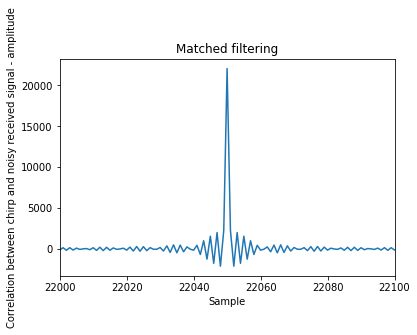

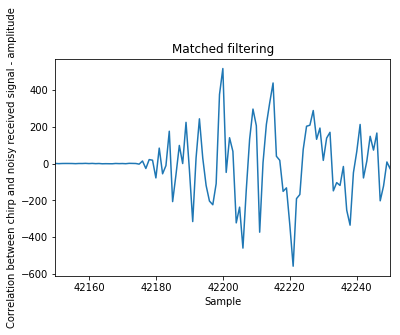

In [52]:
received_signal = convert_wav_to_array('output.wav')
print(n*(L+N))

delay = find_delay(received_signal, chirp_signal) # Calculate delay
print(delay)
chirp_length = len(chirp_signal) # Find length of chirp signal
received_signal_without_delay = received_signal[delay+chirp_length:delay+chirp_length+(n*(N+L))]

51200
9492
(9492,)


ValueError: array split does not result in an equal division

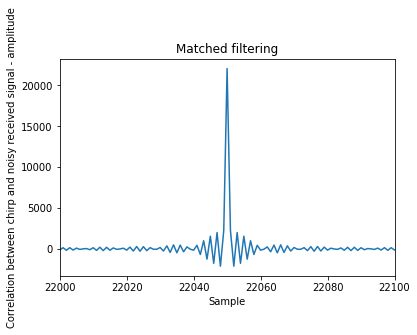

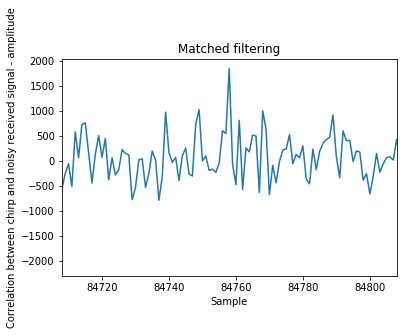

In [28]:
# Receiver

# Estimate channel from input audio file.
h_est, H_est = estimate_channel("input.wav")

h_est = h_est

t = list(range(1, len(h_est)+1))
times = np.array(t)
#times = times / sample_rate
x = times
fig, ax = plt.subplots()
plt.title("Estimated Channel Impulse Response")
plt.xlabel("Sample")
plt.ylabel("Impulse Response Magnitude")
ax.plot(x, h_est)
fig.show()

f = list(range(1, len(H_est)+1))
frequencies = np.array(f)
frequencies = (sample_rate / N) * frequencies
x = frequencies
fig, ax = plt.subplots()
plt.title('Magnitude of DFT of Channel Impulse Response estimated using repeated random OFDM symbols')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative Amplitude')
plt.yscale('log')
ax.plot(x, abs(H_est))
fig.show()



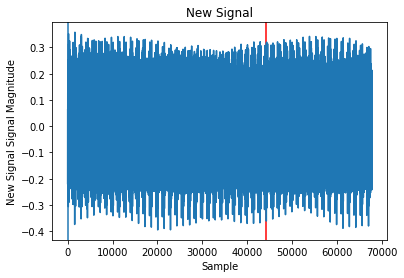

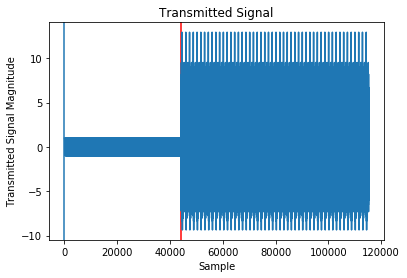

In [19]:
# Plot the transmitted signal
t = list(range(1, len(new_signal)+1))
times = np.array(t)
x = times
fig, ax = plt.subplots()
plt.title("New Signal")
plt.xlabel("Sample")
plt.ylabel("New Signal Signal Magnitude")
plt.axvline(x=0) #Should be at beginning of chirp
chirp_length = len(chirp_signal)
plt.axvline(x=chirp_length, color = 'red') #Should be at end of chirp
#plt.xlim(chirp_length - 100, chirp_length + 100)
#plt.ylim(-1.1, 1.1)
ax.plot(x, new_signal)
fig.show()

# Plot the received signal
t = list(range(1, len(transmitted_signal)+1))
times = np.array(t)
x = times
fig, ax = plt.subplots()
plt.title("Transmitted Signal")
plt.xlabel("Sample")
plt.ylabel("Transmitted Signal Magnitude")
plt.axvline(x=0) #Should be at beginning of chirp
chirp_length = len(chirp_signal)
plt.axvline(x=chirp_length, color = 'red') #Should be at end of chirp
#plt.xlim(chirp_length - 100, chirp_length + 100)
#plt.ylim(-1.1, 1.1)
ax.plot(x, transmitted_signal)
fig.show()